Create a notebook to perform Runge-Kutta integration for multiple coupled variable

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

Define our coupled derivatives to integrate

In [46]:
def dydx(x,y):
    
    #set the derivatives
    
    # our equation is d^2y/dx^2 = -y
    
    #so we can write 
    #dydx = z
    #dzdx = -y
    
    #we will set y = y(0)
    #we will set z = y(1)
    
    #declare an array
    y_derivs = np.zeros(2)
    
    #set dydx = z
    y_derivs[0] = y[1]
    
    #set dzdx = -y
    y_derivs[1] = -1*y[0]
    
    #here we have to return an array
    return y_derivs

In [47]:
def rk4_mv_core(dydx, xi, yi, nv, h):
    
    #declare k? arrays
    k1 = np.zeros(nv)
    k2 = np.zeros(nv)
    k3 = np.zeros(nv)
    k4 = np.zeros(nv)
    k5 = np.zeros(nv)
    k6 = np.zeros(nv)
    
    #define x at 1 step
    x_ipo = xi + h
    
    #declare a temp y array
    y_temp = np.zeros(nv)
    
    #get k1 values
    y_derivs = dydx(xi,yi)
    k1[:] = h*y_derivs[:]
    
    #get k2 values
    y_temp[:] = yi[:] + .2*k1[:]
    y_derivs = dydx(xi+.2*h,y_temp)
    k2[:] = h*y_derivs[:]
    
    #get k3 values
    y_temp[:] = yi[:] +(3/40)*k1 + (9/40)*k2[:]
    y_derivs = dydx(xi+.3*h,y_temp)
    k3[:] = h*y_derivs[:]
    
    #get k4 values
    y_temp[:] = yi[:] + (3/10)*k1 + (-9/10)*k2 + (6/5)*k3[:]
    y_derivs = dydx(xi+(3/5)*h,y_temp)
    k4[:] = h*y_derivs[:]
    
    #get k5 values
    y_temp[:] = yi[:] + (-11/54)*k1 + (5/2)*k2 + (-70/27)*k3 + (35/27)*k4[:]
    y_derivs = dydx(xi+(1)*h,y_temp)
    k5[:] = h*y_derivs[:]
    
    #get k6 values
    y_temp[:] = yi[:] + (1631/55296)*k1 +(175/512)*k2 + (575/13824)*k3 + (44275/110592)*k4 + (253/4096)*k5
    y_derivs = dydx(xi+(7/8)*h,y_temp)
    k6[:] = h*y_derivs[:]
    
    yipo = yi + ((37/378)*k1 + (0)*k2 + (250/621)*k3 + (125/594)*k4 + (0)*k5 + (512/1771)*k6)
    yipostar = yi + ((2825/27648)*k1 + (0)*k2 + (18575/48384)*k3 + (13525/55296)*k4 + (277/14336)*k5 + (1/4)*k6)
    
    return yipo, yipostar

In [48]:
def rk4_mv_ad(dydx,x_i,y_i,nv,h,tol):
    
    #define safety scale
    SAFETY = 0.9
    H_NEW_FAC = 2.0
    
    #set a maximum number of iterations
    imax = 10000
    
    #set an iteration variable
    i = 0
    
    #create an error
    Delta = np.full(nv,2*tol)
    
    #remember the step
    h_step = h
    
    #adjust step
    while(Delta.max()/tol > 1.0):
        
        #estimate our error by taking one step of size h
        #vs. two steps of size h/2
        y_2, y_2star = rk4_mv_core(dydx,x_i,y_i,nv,h_step)
        
        #compute an error
        Delta = np.fabs(y_2 - y_2star)
        print(Delta)
        #if the error is too large, take a smaller step
        if(Delta.max()/tol > 1.0):
            
            #our error is too large, decrease the step
            h_step *= SAFETY * (Delta.max()/tol)**(-0.25)
            
            
        #check iteration
        if(i>=imax):
            print("Too many iteration in rk4_mv_ad()")
            raise StopIteration("Ending after i = ",i)
        
        #iterate
        i+=1
        
    
    #next time, try to tke a bigger step
    h_new = np.fmin(h_step * (Delta.max()/tol)**(-0.9), h_step*H_NEW_FAC)
    
    #return the answer, a new step, and the step we actually took
    return y_2, h_new, h_step

In [49]:
def rk4_mv(dfdx,a,b,y_a,tol):
    
    #dfdx is the derivative wrtx
    #a is the lower bound
    #b is the upper bound
    #y_a are the boundary conditions
    #tol is the tolerance for integrating y
    
    #define our starting step
    xi = a
    yi = y_a.copy()
    
    #an initial step size == make very small!
    h = 1.0e-3 * (b-a)
    
    #set a maximum number of iterations
    imax = 10000
    
    #set an iteration variable 
    i = 0 

    #set the number of coupled odes to the size
    #size of y_a
    nv = len(y_a)

    #set the initial conditions
    x = np.full(1,a)
    y = np.full((1,nv),y_a)
    
    #set a flag
    flag = 1
    
    #loop until we reach the right side
    while(flag):
        
        #calculate y_i+1
        yi_new, h_new, h_step = rk4_mv_ad(dydx,xi,yi,nv,h,tol)
        
        #update the step
        h = h_new
        
        #prevent an overshoot
        if(xi+h_step>b):
            
            #take a smaller step
            h = b-xi
            
            #recalculate y_i+1
            yi_new , h_new, h_step = rk4_mv_ad(dydx,xi,yi,nv,h,tol)
            
            #break
            flag = 0
            
        #update values
        xi += h_step
        yi[:] = yi_new[:]
            
        #add the step to the arrays
        x = np.append(x,xi)
        y_new = np.zeros((len(x),nv))
        y_new[0:len(x)-1,:] = y
        y_new[-1,:] = yi[:]
        del y
        y = y_new
            
        #prevent too many iterations
        if(i>=imax):
            
            print("Maximum iterations reached.")
            raise StopIteration("Iteration number = ",i)
                
        #iterate
        i += 1 
            
        #output some information
        s = "i = %3d/t  x = %9.8f/t  h = %9.8f/t  b=%9.8f" % (i,xi, h_step, b)
        print(s)
            
        #break if new xi is == b 
        if(xi==b):
            flag = 0
                
    #return the answer
    return x,y

In [50]:
a = 0.0
b = 2.0 * np.pi

y_0 = np.zeros(2)
y_0[0] = 0.0
y_0[1] = 1.0
nv = 2

tolerance = 1.0e-6

#perform the integration
x,y = rk4_mv(dydx,a,b,y_0,tolerance)

[2.20743562e-15 0.00000000e+00]
i =   1/t  x = 0.00628319/t  h = 0.00628319/t  b=6.28318531
[7.06448788e-14 2.22044605e-16]
i =   2/t  x = 0.01884956/t  h = 0.01256637/t  b=6.28318531
[2.26087205e-12 0.00000000e+00]
i =   3/t  x = 0.04398230/t  h = 0.02513274/t  b=6.28318531
[7.23848481e-11 4.56079619e-13]
i =   4/t  x = 0.09424778/t  h = 0.05026548/t  b=6.28318531
[2.32086808e-09 4.40831815e-11]
i =   5/t  x = 0.19477874/t  h = 0.10053096/t  b=6.28318531
[7.48321640e-08 3.37796791e-09]
i =   6/t  x = 0.39584067/t  h = 0.20106193/t  b=6.28318531
[2.46262056e-06 2.54359460e-07]
[4.56516505e-07 8.42335329e-08]
i =   7/t  x = 0.68474429/t  h = 0.28890362/t  b=6.28318531
[1.52247853e-05 4.30909841e-06]
[2.56400698e-07 1.36697023e-07]
i =   8/t  x = 0.94800599/t  h = 0.26326170/t  b=6.28318531
[8.24675001e-06 5.30816121e-06]
[2.90481247e-07 2.65916373e-07]
i =   9/t  x = 1.22763968/t  h = 0.27963368/t  b=6.28318531
[9.02162409e-06 9.87403130e-06]
[2.23444451e-07 3.62019367e-07]
i =  10/t  x

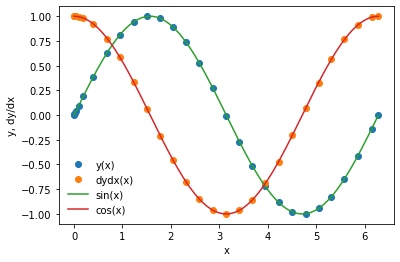

In [51]:
plt.plot(x,y[:,0],'o',label='y(x)')
plt.plot(x,y[:,1],'o',label='dydx(x)')
xx = np.linspace(0,2.0*np.pi,1000)
plt.plot(xx,np.sin(xx),label='sin(x)')
plt.plot(xx,np.cos(xx),label='cos(x)')
plt.xlabel('x')
plt.ylabel('y, dy/dx')
plt.legend(frameon=False)

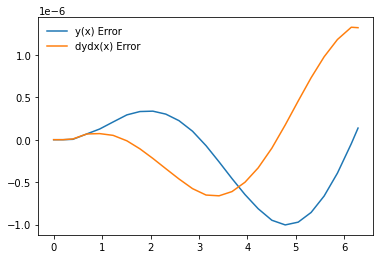

In [52]:
sine = np.sin(x)
cosine = np.cos(x)

y_error = (y[:,0]-sine)
dydx_error = (y[:,1]-cosine)

plt.plot(x,y_error,label="y(x) Error")
plt.plot(x,dydx_error,label="dydx(x) Error")
plt.legend(frameon=False)
